In [ ]:
!pip install segmentation-models-pytorch

# Using ISIC 2017 dataset (has superpixels)
from google.colab import drive
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
import numpy as np

drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=14d1e641493c80bc2f886f71aaba422597e6944d6d3cb37c9cebba87c44790c9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b8baf8d1dbfaba1fb3387e4166a8753cda867b193d951e77900d7baa3668be89
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
train_image_dir = '/content/drive/MyDrive/ISIC-2017_Training_Data/'
train_mask_dir = '/content/drive/MyDrive/ISIC-2017_Training_Part1_GroundTruth/'
val_image_dir = '/content/drive/MyDrive/ISIC-2017_Validation_Data/'
val_mask_dir = '/content/drive/MyDrive/ISIC-2017_Validation_Part1_GroundTruth/'

#test_image_dir = '/content/drive/MyDrive/ISIC-2017_Test_v2_Data/'
#test_mask_dir = '/content/drive/MyDrive/ISIC-2017_Test_v2_Part1_GroundTruth/'

class MelanomaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_name = image_name.replace('.jpg', '_superpixels.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        superpixel_mask_name = image_name.replace('.jpg', '.png')
        superpixel_mask_path = os.path.join(self.image_dir, superpixel_mask_name)
        superpixel_mask = Image.open(superpixel_mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            superpixel_mask = self.transform(superpixel_mask)

        return image, superpixel_mask, mask

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

batch_size = 8



In [ ]:
train_dataset = MelanomaDataset(train_image_dir, train_mask_dir, transform=train_transforms)
val_dataset = MelanomaDataset(val_image_dir, val_mask_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

generator = torch.optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE)
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, preds, targets):
        dice = self.dice_loss(preds, targets)
        bce = self.bce_loss(preds, targets)
        return self.dice_weight * dice + self.bce_weight * bce

loss_fn = CombinedLoss()

def calculate_iou(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def train_one_epoch(model, optimizer, data_loader, loss_fn, device):
    model.train()
    total_loss = 0
    total_iou = 0

    for images, superpixels, ground_truths in data_loader:
        images = images.to(device)
        ground_truths = ground_truths.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_fn(predictions, ground_truths)
        loss.backward()
        optimizer.step()

        iou = calculate_iou(predictions, ground_truths)
        total_iou += iou
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou

def validate_one_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for images, superpixels, ground_truths in data_loader:
            images = images.to(device)
            ground_truths = ground_truths.to(device)

            predictions = model(images)
            loss = loss_fn(predictions, ground_truths)

            iou = calculate_iou(predictions, ground_truths)
            total_iou += iou
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
best_iou = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_iou = 0

    for batch_idx, (images, superpixels, ground_truths) in enumerate(train_loader):
        images = images.to(device)
        ground_truths = ground_truths.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_fn(predictions, ground_truths)
        loss.backward()
        optimizer.step()

        iou = calculate_iou(predictions, ground_truths)
        total_iou += iou
        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}, IoU: {iou:.4f}")

    avg_train_loss = total_loss / len(train_loader)
    avg_train_iou = total_iou / len(train_loader)
    val_loss, val_iou = validate_one_epoch(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_model2.pth')
        print(f"Model saved with Validation IoU: {val_iou:.4f}")


In [ ]:
import cv2
import numpy as np
import os

def draw_bounding_box(image, mask, color=(255, 0, 0), thickness=2, min_size=10):
    mask_binary = (mask > 0.5).astype(np.uint8)
    y_indices, x_indices = np.where(mask_binary)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None, None
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()
    if (max_x - min_x) < min_size or (max_y - min_y) < min_size:
        return None, None
    if len(image.shape) == 2:
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else:
        image = (image * 255).astype(np.uint8)
    boxed_image = cv2.rectangle(image.copy(), (min_x, min_y), (max_x, max_y), color, thickness)
    bounding_box = (min_x, min_y, max_x, max_y)
    return boxed_image, bounding_box

def display_bounding_boxes(model, images, output_folder="/content/drive/MyDrive/New_U-Net_Results/2016/", min_size=10):
    os.makedirs(output_folder, exist_ok=True)
    sample_images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    predictions = model.predict(images).reshape(-1, IMG_HEIGHT, IMG_WIDTH)

    no_bbox_count = 0
    for i, (image, mask) in enumerate(zip(sample_images, predictions)):
        boxed_prediction, bounding_box = draw_bounding_box(image, mask, min_size=min_size)
        original_image_name = f"test_image_{i}"

        if boxed_prediction is not None and bounding_box is not None:
            output_path = os.path.join(output_folder, f"{original_image_name}")
            cv2.imwrite(output_path, cv2.cvtColor(boxed_prediction, cv2.COLOR_RGB2BGR))
            bbox_data_path = os.path.join(output_folder, f"{original_image_name}_box_coordinates.txt")
            with open(bbox_data_path, 'w') as f:
                f.write(str(bounding_box))
        else:
            no_bbox_count += 1

    print(f"Number of images without bounding boxes: {no_bbox_count}")


# display_bounding_boxes(model, test_images, output_folder="/content/drive/MyDrive/bounded_predictions4", min_size=10)


In [ ]:
test_image_dir = '/content/drive/MyDrive/ISIC_2020_Test_Input/'
#test_mask_dir = '/content/drive/MyDrive/ISIC-2017_Test_v2_Part1_GroundTruth/'
output_folder = '/content/drive/MyDrive/New_U-Net_Results/2020/'


In [ ]:
def evaluate_model_with_original_images(
    model,
    data_loader,
    device,
    test_image_dir,
    output_folder='/content/drive/MyDrive/New_U-Net_Results/2020/'
):
    model.eval()

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    stored_image_count = 0
    with torch.no_grad():
        for i, (images, image_names) in enumerate(data_loader):
            images = images.to(device)
            predictions = model(images)
            pred_mask = torch.sigmoid(predictions).cpu().numpy()[0, 0]
            bounding_box = draw_bounding_box(pred_mask, min_size=10)
            if bounding_box is not None:
                x_min, y_min, x_max, y_max = bounding_box
                original_image_name = image_names[0]
                original_image_path = os.path.join(test_image_dir, original_image_name)
                original_image = cv2.imread(original_image_path)
                original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                h, w, _ = original_image.shape
                pred_h, pred_w = pred_mask.shape
                scale_x = w / pred_w
                scale_y = h / pred_h
                x_min = int(x_min * scale_x)
                x_max = int(x_max * scale_x)
                y_min = int(y_min * scale_y)
                y_max = int(y_max * scale_y)
                x_min, x_max = max(0, x_min), min(w, x_max)
                y_min, y_max = max(0, y_min), min(h, y_max)
                cropped_original_image = original_image[y_min:y_max, x_min:x_max]
                cropped_image_path = os.path.join(output_folder, original_image_name)
                cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_original_image, cv2.COLOR_RGB2BGR))
                stored_image_count += 1
                bbox_data_path = os.path.join(
                    output_folder, f"{os.path.splitext(original_image_name)[0]}_box_coordinates.txt"
                )
                with open(bbox_data_path, 'w') as f:
                    f.write(f"x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}")

                print(f"Saved cropped image: {cropped_image_path}")
                print(f"Saved bounding box coordinates: {bbox_data_path}")
            else:
                print(f"No bounding box found for image: {image_names[0]}")


    print(f"\nTotal cropped images saved: {stored_image_count}")


In [ ]:
test_dataset = MelanomaDataset(test_image_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluate_model_with_original_images(model, test_loader, device, test_image_dir, output_folder)


Streaming output truncated to the last 5000 lines.
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_1221363_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_4135644.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_4135644_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_5141003.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_5141003_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_5370884.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_5370884_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_6622777.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2020/ISIC_6622777_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Resu

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Test directory
#test_image_dir = '/content/drive/MyDrive/ISIC_2017_Test_v2_Data/'

# Transformation (resize and convert to tensor)
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_dataset = MelanomaDataset(test_image_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluate_model_with_original_images(model, test_loader, device, test_image_dir, output_folder)



Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013414.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013414_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013416.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013416_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013455.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013455_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013457.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013457_box_coordinates.txt
Saved cropped image: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013459.jpg
Saved bounding box coordinates: /content/drive/MyDrive/New_U-Net_Results/2017/ISIC_0013459_box_coordinates.txt
Saved cropped image: /con

In [ ]:
def visualize_predictions_with_bounding_boxes(
    model,
    data_loader,
    device,
    test_image_dir,
    num_images=10
):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, image_names in data_loader:
            images = images.to(device)
            predictions = model(images)
            pred_mask = torch.sigmoid(predictions).cpu().numpy()[0, 0]
            bounding_box = draw_bounding_box(pred_mask, min_size=10)
            if bounding_box is not None:
                x_min, y_min, x_max, y_max = bounding_box
                original_image_name = image_names[0]
                original_image_path = os.path.join(test_image_dir, original_image_name)
                original_image = cv2.imread(original_image_path)
                original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                h, w, _ = original_image.shape
                pred_h, pred_w = pred_mask.shape
                scale_x = w / pred_w
                scale_y = h / pred_h
                x_min = int(x_min * scale_x)
                x_max = int(x_max * scale_x)
                y_min = int(y_min * scale_y)
                y_max = int(y_max * scale_y)
                original_with_bbox = original_image.copy()
                cv2.rectangle(original_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness=5)
                mask_with_bbox = (pred_mask * 255).astype(np.uint8)
                mask_with_bbox = cv2.cvtColor(mask_with_bbox, cv2.COLOR_GRAY2RGB)
                cv2.rectangle(mask_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness=5)
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(original_image)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_with_bbox)
                plt.title("Predicted Mask with Bounding Box")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(original_with_bbox)
                plt.title("Original Image with Bounding Box")
                plt.axis("off")

                plt.show()

                count += 1
                if count >= num_images:
                    break


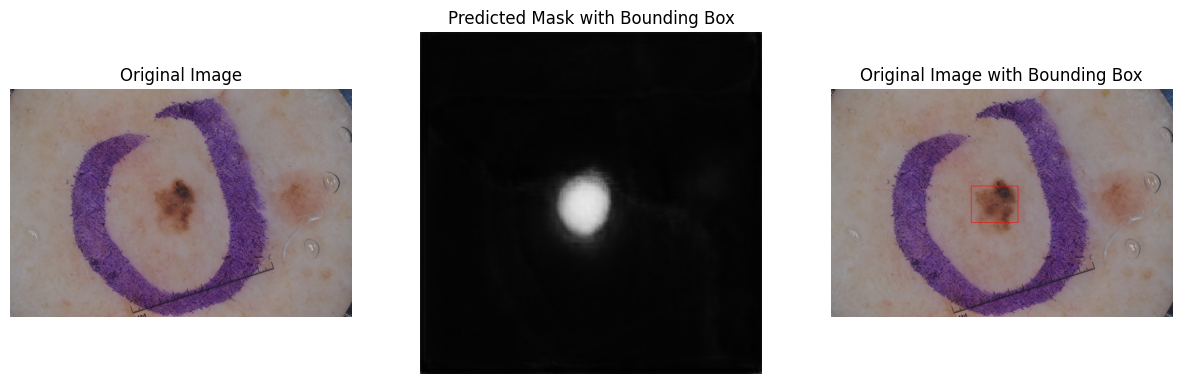

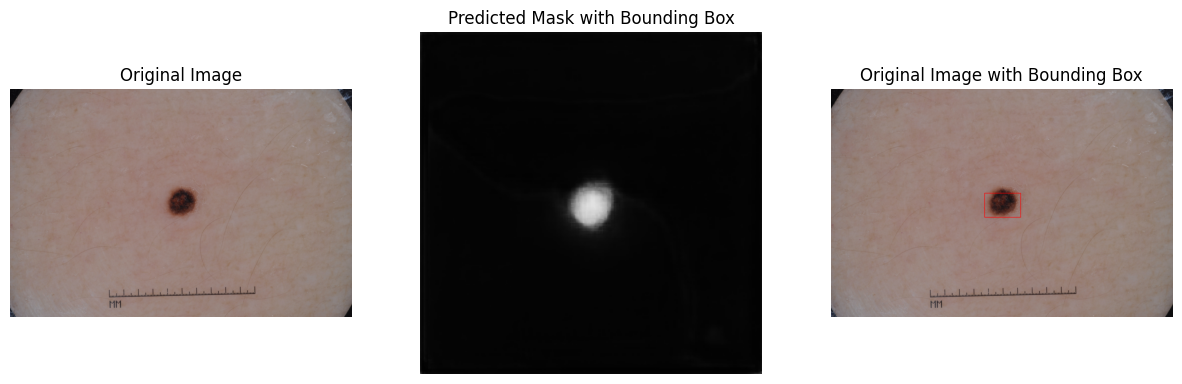

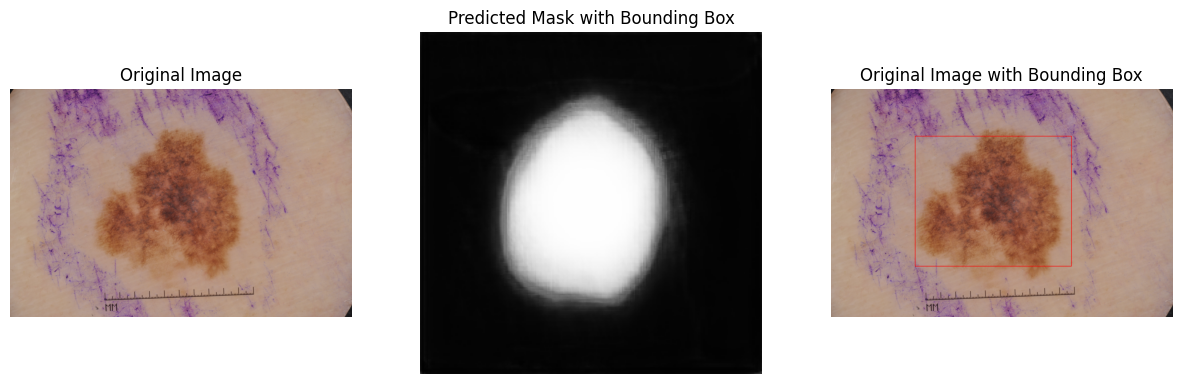

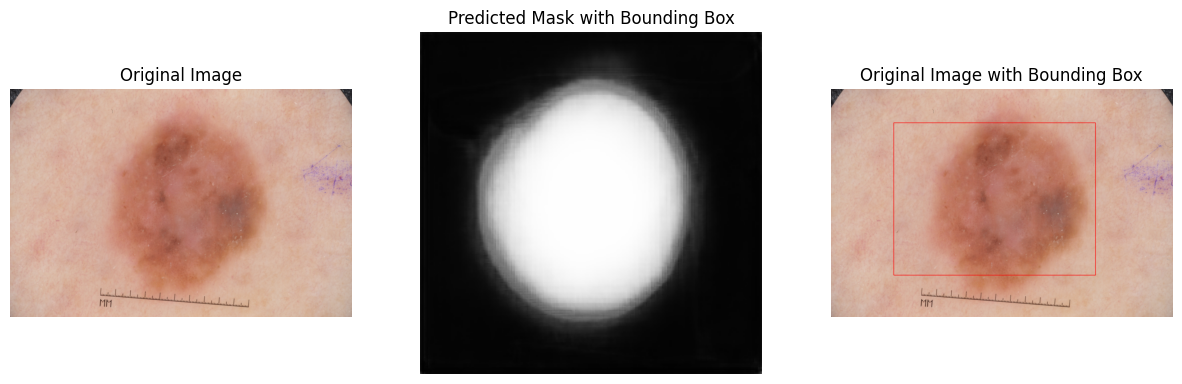

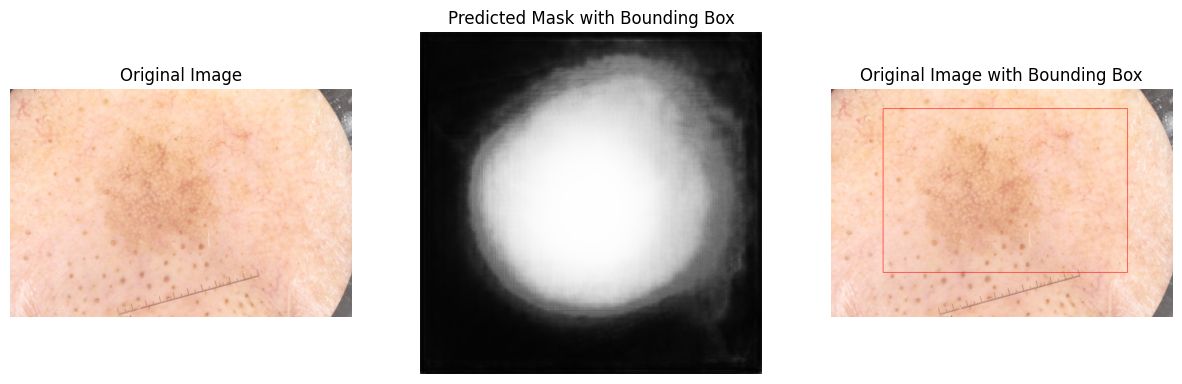

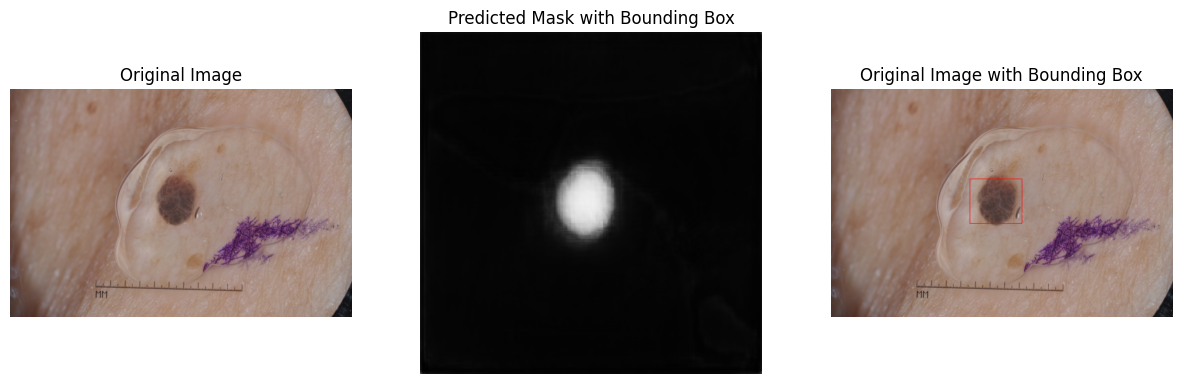

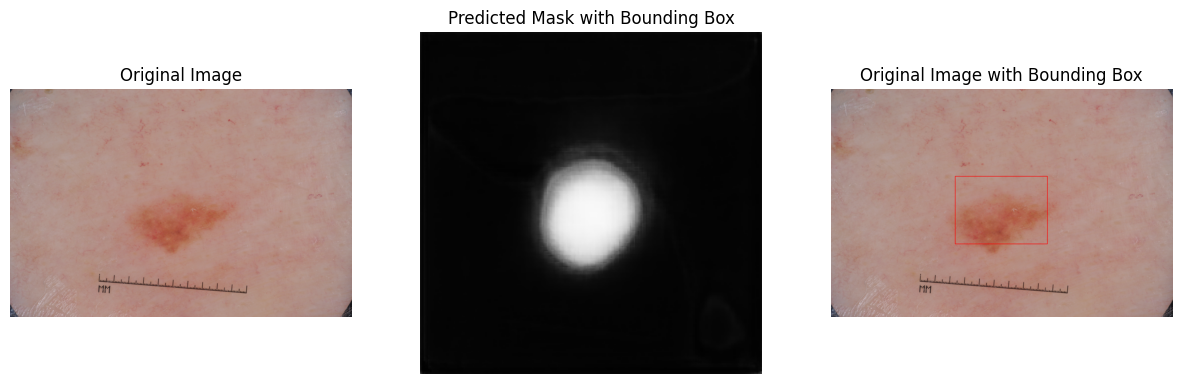

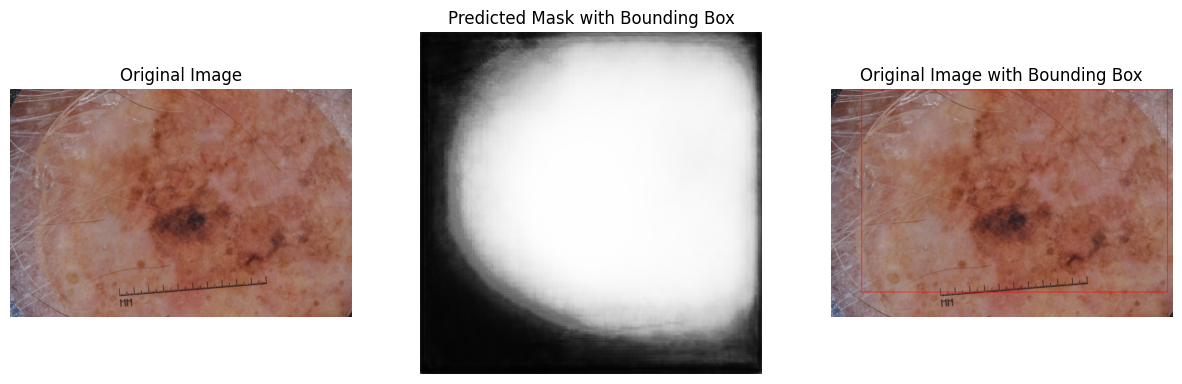

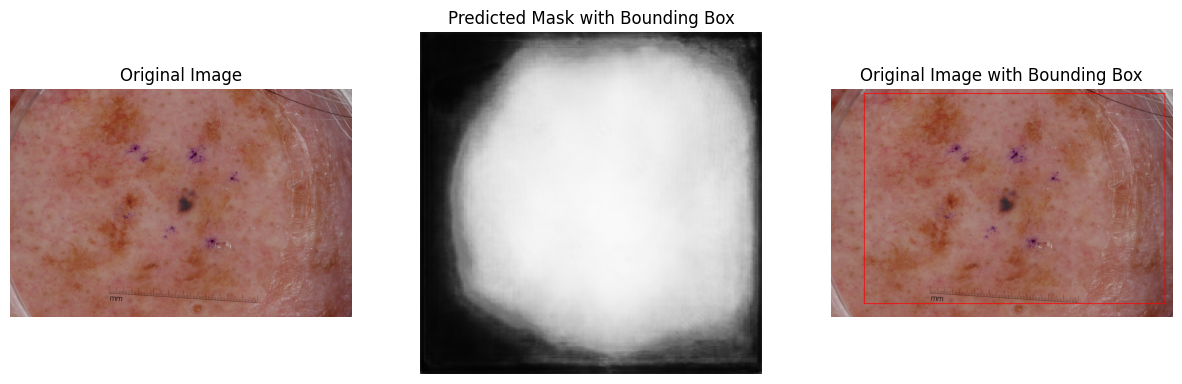

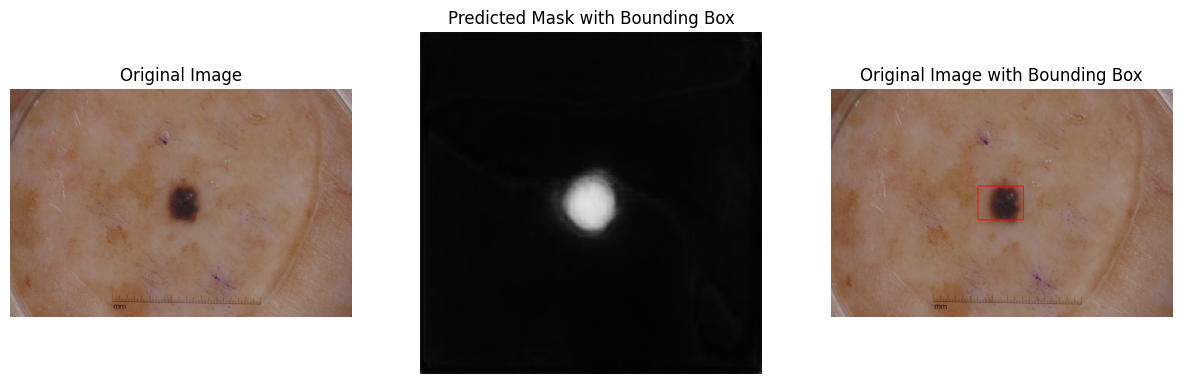

In [ ]:
visualize_predictions_with_bounding_boxes(
    model=model,
    data_loader=test_loader,
    device=device,
    test_image_dir=test_image_dir,
    num_images=10
)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model2.pth'))
model = model.to(device)

<ipython-input-27-9c6f226886f4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/best_model2.pth'))


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class MelanomaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, image_name


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model2.pth'))
model = model.to(device)

def evaluate_model(model, data_loader, device, output_folder='/content/drive/MyDrive/New_U-Net_Results/2016/'):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_accuracy = 0

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with torch.no_grad():
        for i, (images, superpixels, ground_truths) in enumerate(data_loader):
            images = images.to(device)
            ground_truths = ground_truths.to(device)
            predictions = model(images)
            loss = loss_fn(predictions, ground_truths)
            iou = calculate_iou(predictions, ground_truths)
            accuracy = ((torch.sigmoid(predictions) > 0.5) == ground_truths).float().mean().item()
            total_loss += loss.item()
            total_iou += iou
            total_accuracy += accuracy
            pred_mask = torch.sigmoid(predictions).cpu().numpy()[0, 0]
            boxed_prediction, bounding_box = draw_bounding_box(pred_mask, pred_mask, min_size=10)
            if bounding_box is not None:
                x_min, y_min, x_max, y_max = [int(coord) for coord in bounding_box]
                cropped_mask = pred_mask[y_min:y_max, x_min:x_max]
                original_image_name = test_dataset.image_names[i]
                cropped_mask_path = os.path.join(output_folder, f"{original_image_name}")
                cv2.imwrite(cropped_mask_path, (cropped_mask * 255).astype(np.uint8))
                bbox_data_path = os.path.join(output_folder, f"{original_image_name}_box_coordinates.txt")
                with open(bbox_data_path, 'w') as f:
                    f.write(str(bounding_box))
                print(f"Saved cropped mask: {cropped_mask_path}")
                print(f"Saved bounding box coordinates for: {original_image_name}")
            else:
                print(f"No bounding box found for image: {test_dataset.image_names[i]}")


    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test IoU: {avg_iou:.4f}, Test Accuracy: {avg_accuracy:.4f}")



test_dataset = MelanomaDataset(test_image_dir, test_mask_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluate_model(model, test_loader, device, output_folder)
#evaluate_model(model, test_loader, device, output_folder)
